In [47]:
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import random
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import pickle
import os

In [48]:
def getIndices(y, n):
    zeros = [y.index[i] for i,j in enumerate(y) if j == 0]
    ones = [y.index[i] for i,j in enumerate(y) if j == 1]
    rzeros = n*len(zeros)//len(y)
    rones = n*len(ones)//len(y)
    ans = (random.sample(zeros, rzeros) + random.sample(ones, rones))
    return random.sample(ans, len(ans))


def resample(train, train_class, model):
    x, y = model.fit_sample(train, train_class)
#     print(sorted(Counter(y).items()))
    
    return (x, y)

def predict(train, train_class, test, test_class, model, method='normal'):
    
    def gini_normal(y, pred):
        fpr, tpr, thr = metrics.roc_curve(y, pred, pos_label=1)
        g = 2 * metrics.auc(fpr, tpr) -1
        return g
    
    def gini(actual, pred, cmpcol = 0, sortcol = 1):
        assert( len(actual) == len(pred) )
        all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
        all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
        totalLosses = all[:,0].sum()
        giniSum = all[:,0].cumsum().sum() / totalLosses

        giniSum -= (len(actual) + 1) / 2.
        return giniSum / len(actual)

    def normalized_gini(a, p):
         return gini(a, p) / gini(a, a)
    
    
    model = model.fit(train, train_class)
    
    if method == 'normal':
        predictions = model.predict(test)
#         print (gini_normal(test_class, predictions))
        return (gini_normal(test_class, predictions))
    else:
        predictions = model.predict_proba(test)[:,1]
#         predictions = model.predict(test)
#         print (normalized_gini(test_class, predictions))
        return (normalized_gini(test_class, predictions))
    

In [49]:
train = pd.read_csv('data/train.csv')
test_file = pd.read_csv('data/test.csv')


In [50]:
# input NaN instead of -1 for missing values
train = train.replace(-1, np.NaN)

# drop id column
train = train.drop(['id'],axis=1)

train = train.drop(['ps_car_03_cat','ps_car_05_cat','ps_reg_03'],axis=1)

# missing values
mis = train.isnull().sum()
mis[np.argsort(mis)[::-1]][:15]

#impute
for e in mis[mis>0].keys():
    value = train[e].value_counts().idxmax()
    train[e] = train[e].fillna(value)

train = train.dropna(axis=0)

cols = train.columns
cols_cat = [e for e in cols[1:]  if e.endswith('cat')]
for e in cols_cat:
    train = pd.concat([train,pd.get_dummies(train[e],prefix=e)], axis=1 )

#Drop irrelevant columns
train_x = train.drop(cols_cat,axis=1)

df_train_X = train_x.iloc[:,1:].values
df_train_y = train_x.iloc[:,0].values



In [51]:
train, test, train_class, test_class = train_test_split( df_train_X, df_train_y, test_size=0.3, random_state=0,stratify=df_train_y)

In [6]:
#resampling

# sampled_indices_small = getIndices(train_class, 50000)
# train_small = train.loc[sampled_indices_small]
# train_sample_smal1, train_class_sample_small = resample(train_small, train_class, SMOTETomek())

# sampled_indices_large = getIndices(train_class, 100000)
# train_large = train.loc[sampled_indices_large]
# train_sample_large, train_class_sample_large = resample(train_large, train_class, SMOTETomek())


In [7]:
##dimensionality reduction

svd_50 = TruncatedSVD(n_components=50, n_iter=7)
train_r_50 = svd_50.fit_transform(train)
test_r_50 = svd_50.transform(test)

svd_40 = TruncatedSVD(n_components=40, n_iter=7)
train_r_40 = svd_40.fit_transform(train)
test_r_40 = svd_40.transform(test)

In [79]:
model_lr = LogisticRegression(class_weight = 'balanced')
lr_cross_score = []
lr_cross_score_reduced_50 = []
lr_cross_score_reduced_40 = []
lr_cross_score_test = []

for i in range(0,5):
    
    
    model_lr_test = LogisticRegression(class_weight = 'balanced')
    lr_score_test = predict(train, train_class, test, test_class, model_lr_test, 'normalized')
    lr_cross_score_test.append(lr_score_test)
    
    
    lr_score = predict(train, train_class, test, test_class, model_lr, 'normalized')
    lr_score_reduced_50 = predict(train_r_50, train_class, test_r_50, test_class, model_lr, 'normalized')
    lr_score_reduced_40 = predict(train_r_40, train_class, test_r_40, test_class, model_lr, 'normalized')
    
    lr_cross_score.append(lr_score)
    lr_cross_score_reduced_50.append(lr_score_reduced_50)
    lr_cross_score_reduced_40.append(lr_score_reduced_40)
    
lr_cross_score_mean = str(np.mean(lr_cross_score))
lr_cross_score_reduced_50_mean = str(np.mean(lr_cross_score_reduced_50))
lr_cross_score_reduced_40_mean = str(np.mean(lr_cross_score_reduced_40))

lr_cross_score_mean_test = str(np.mean(lr_cross_score_test))

print(lr_cross_score_mean_test)

print(lr_cross_score_mean)
print(lr_cross_score_reduced_50_mean)
print(lr_cross_score_reduced_40_mean)

0.23853769012
0.23853769012
0.233208644438
0.229655974703


In [12]:
model_sgd = SGDClassifier(class_weight='balanced')
sgd_cross_score = []
sgd_cross_score_reduced_50 = []
sgd_cross_score_reduced_40 = []

for i in range(0,5):

    sgd_score = predict(train, train_class, test, test_class, model_sgd)
    sgd_score_reduced_50 = predict(train_r_50, train_class, test_r_50, test_class, model_sgd)
    sgd_score_reduced_40 = predict(train_r_40, train_class, test_r_40, test_class, model_sgd)

    sgd_cross_score.append(sgd_score)
    sgd_cross_score_reduced_50.append(sgd_score_reduced_50)
    sgd_cross_score_reduced_40.append(sgd_score_reduced_40)
    
sgd_cross_score_mean = str(np.mean(sgd_cross_score))
sgd_cross_score_reduced_50_mean = str(np.mean(sgd_cross_score_reduced_50))
sgd_cross_score_reduced_40_mean = str(np.mean(sgd_cross_score_reduced_40))

print(sgd_cross_score_mean)
print(sgd_cross_score_reduced_50_mean)
print(sgd_cross_score_reduced_40_mean)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.0629937626403
0.0534319160363
0.0426984972146


In [13]:
model_gauss = GaussianNB()
gauss_cross_score = []
gauss_cross_score_reduced_50 = []
gauss_cross_score_reduced_40 = []

for i in range(0,5):
    
    gauss_score = predict(train, train_class, test, test_class, model_gauss, 'normalized')
    gauss_score_reduced_50 = predict(train_r_50, train_class, test_r_50, test_class, model_gauss, 'normalized')
    gauss_score_reduced_40 = predict(train_r_40, train_class, test_r_40, test_class, model_gauss, 'normalized')
    
    gauss_cross_score.append(gauss_score)
    gauss_cross_score_reduced_50.append(gauss_score_reduced_50)
    gauss_cross_score_reduced_40.append(gauss_score_reduced_40)
    
gauss_cross_score_mean = str(np.mean(gauss_cross_score))
gauss_cross_score_reduced_50_mean = str(np.mean(gauss_cross_score_reduced_50))
gauss_cross_score_reduced_40_mean = str(np.mean(gauss_cross_score_reduced_40))

print(gauss_cross_score_mean)
print(gauss_cross_score_reduced_50_mean)
print(gauss_cross_score_reduced_40_mean)

0.161738369212
0.206386828673
0.210387807657


In [14]:
model_bernoulli = BernoulliNB()
bernoulli_cross_score = []
bernoulli_cross_score_reduced_50 = []
bernoulli_cross_score_reduced_40 = []

for i in range(0,5):
    
    bernoulli_score = predict(train, train_class, test, test_class, model_bernoulli, 'normalized')
    bernoulli_score_reduced_50 = predict(train_r_50, train_class, test_r_50, test_class, model_bernoulli, 'normalized')
    bernoulli_score_reduced_40 = predict(train_r_40, train_class, test_r_40, test_class, model_bernoulli, 'normalized')
    
    bernoulli_cross_score.append(bernoulli_score)
    bernoulli_cross_score_reduced_50.append(bernoulli_score_reduced_50)
    bernoulli_cross_score_reduced_40.append(bernoulli_score_reduced_40)
    
bernoulli_cross_score_mean = str(np.mean(bernoulli_cross_score))
bernoulli_cross_score_reduced_50_mean = str(np.mean(bernoulli_cross_score_reduced_50))
bernoulli_cross_score_reduced_40_mean = str(np.mean(bernoulli_cross_score_reduced_40))

print(bernoulli_cross_score_mean)
print(bernoulli_cross_score_reduced_50_mean)
print(bernoulli_cross_score_reduced_40_mean)

0.219987702007
0.195503501183
0.189886904934


In [15]:
model_et = ExtraTreeClassifier(class_weight='balanced')
et_cross_score = []
et_cross_score_reduced_50 = []
et_cross_score_reduced_40 = []

for i in range(0,5):
    
    et_score = predict(train, train_class, test, test_class, model_et, 'normalized')
    et_score_reduced_50 = predict(train_r_50, train_class, test_r_50, test_class, model_et, 'normalized')
    et_score_reduced_40 = predict(train_r_40, train_class, test_r_40, test_class, model_et, 'normalized')
    
    et_cross_score.append(et_score)
    et_cross_score_reduced_50.append(et_score_reduced_50)
    et_cross_score_reduced_40.append(et_score_reduced_40)
    
et_cross_score_mean = str(np.mean(et_cross_score))
et_cross_score_reduced_50_mean = str(np.mean(et_cross_score_reduced_50))
et_cross_score_reduced_40_mean = str(np.mean(et_cross_score_reduced_40))

print(et_cross_score_mean)
print(et_cross_score_reduced_50_mean)
print(et_cross_score_reduced_40_mean)

0.00880862383566
0.007524782386
0.00970036370429


In [16]:
model_dt = DecisionTreeClassifier(class_weight='balanced')
dt_cross_score = []
dt_cross_score_reduced_50 = []
dt_cross_score_reduced_40 = []

for i in range(0,5):
    
    dt_score = predict(train, train_class, test, test_class, model_dt, 'normalized')
    dt_score_reduced_50 = predict(train_r_50, train_class, test_r_50, test_class, model_dt, 'normalized')
    dt_score_reduced_40 = predict(train_r_40, train_class, test_r_40, test_class, model_dt, 'normalized')
    
    dt_cross_score.append(dt_score)
    dt_cross_score_reduced_50.append(dt_score_reduced_50)
    dt_cross_score_reduced_40.append(dt_score_reduced_40)
    
dt_cross_score_mean = str(np.mean(dt_cross_score))
dt_cross_score_reduced_50_mean = str(np.mean(dt_cross_score_reduced_50))
dt_cross_score_reduced_40_mean = str(np.mean(dt_cross_score_reduced_40))

print(dt_cross_score_mean)
print(dt_cross_score_reduced_50_mean)
print(dt_cross_score_reduced_40_mean)

0.0128422821786
0.00781965429188
0.00548379440161


In [17]:
model_rf = RandomForestClassifier()
rf_cross_score = []
rf_cross_score_reduced_50 = []
rf_cross_score_reduced_40 = []

for i in range(0,5):
    
    rf_score = predict(train, train_class, test, test_class, model_rf, 'normalized')
    rf_score_reduced_50 = predict(train_r_50, train_class, test_r_50, test_class, model_rf, 'normalized')
    rf_score_reduced_40 = predict(train_r_40, train_class, test_r_40, test_class, model_rf, 'normalized')
    
    rf_cross_score.append(rf_score)
    rf_cross_score_reduced_50.append(rf_score_reduced_50)
    rf_cross_score_reduced_40.append(rf_score_reduced_40)
    
rf_cross_score_mean = str(np.mean(rf_cross_score))
rf_cross_score_reduced_50_mean = str(np.mean(rf_cross_score_reduced_50))
rf_cross_score_reduced_40_mean = str(np.mean(rf_cross_score_reduced_40))

print(rf_cross_score_mean)
print(rf_cross_score_reduced_50_mean)
print(rf_cross_score_reduced_40_mean)

0.0672374128616
0.0669439859334
0.0622574966587


In [18]:
# model_mlp = MLPClassifier()
# predict(train, train_class, test, test_class, model_mlp)


In [19]:
# model_extraTrees = ExtraTreesClassifier()
# predict(train, train_class, test, test_class, model_extraTrees)

In [20]:
# model_ab = AdaBoostClassifier()
# predict(train, train_class, test, test_class, model_ab)


In [21]:
# model_kn = KNeighborsClassifier()
# predict(train, train_class, test, test_class, model_kn)

In [22]:
# model_lsvc = LinearSVC(class_weight='balanced')
# predict(train, train_class, test, test_class, model_lsvc)


In [23]:
# model_svc = SVC(class_weight='balanced')
# predict(train, train_class, test, test_class, model_svc)

In [24]:
# model_gp = GaussianProcessClassifier()
# predict(train, train_class, test, test_class, model_gp)

In [53]:
modelgb = GradientBoostingClassifier(learning_rate=0.03, subsample=0.9, 
                                max_depth=5, max_features='auto')
gb_cross_score = []
gb_cross_score_reduced_50 = []
gb_cross_score_reduced_40 = []

for i in range(0,5):
    
    gb_score = predict(train, train_class, test, test_class, modelgb, 'normalized')
    gb_score_reduced_50 = predict(train_r_50, train_class, test_r_50, test_class, modelgb, 'normalized')
    gb_score_reduced_40 = predict(train_r_40, train_class, test_r_40, test_class, modelgb, 'normalized')

    gb_cross_score.append(gb_score)
    gb_cross_score_reduced_50.append(gb_score_reduced_50)
    gb_cross_score_reduced_40.append(gb_score_reduced_40)
    
gb_cross_score_mean = str(np.mean(gb_cross_score))
gb_cross_score_reduced_50_mean = str(np.mean(gb_cross_score_reduced_50))
gb_cross_score_reduced_40_mean = str(np.mean(gb_cross_score_reduced_40))

print(gb_cross_score_mean)
print(gb_cross_score_reduced_50_mean)
print(gb_cross_score_reduced_40_mean)

0.261405318101
0.23255453571
0.230905499986


In [26]:
test = test_file.replace(-1, np.NaN)
test = test.drop(['ps_car_03_cat','ps_car_05_cat','ps_reg_03'],axis=1)
test.head()
# missing values
mis_t = test.isnull().sum()
mis_t[np.argsort(mis_t)[::-1]][:15]
#impute
for e in mis_t[mis_t>0].keys():
    value = test[e].value_counts().idxmax()
    test[e] = test[e].fillna(value)
    
for e in cols_cat:
    test = pd.concat([test,pd.get_dummies(test[e],prefix=e)], axis=1 )
#Drop irrelevant columns
test_b = test.drop(cols_cat,axis=1)

test_b_col = test_b[train_x.columns[1:]]
test_b_col = test_b_col.values


In [27]:
def writeResults(model, name, test, test_columns):
    pickle.dump(model, open(os.path.join('pkl_objects', 'model_'+name+'.pkl'), 'wb'), protocol=2)
    gb = pickle.load(open('./pkl_objects/model_'+name+'.pkl', 'rb'))
    preds = gb.predict_proba(test_columns)[:,1]
    df_submit = pd.DataFrame({'id':test.id,'target':preds},index=range(preds.shape[0]))
    df_submit.head()
    df_submit.to_csv('data/model_'+name+'.csv',index=False)

In [72]:
gauss_cross_score_test = []

for i in range(0,5):
    model_gauss_test = GaussianNB()
    gauss_score_test = predict(train, train_class, test, test_class, model_gauss_test, 'normalized')
    gauss_cross_score_test.append(gauss_score_test)
    
    
gauss_cross_score_mean_test = str(np.mean(gauss_cross_score_test))

print(gauss_cross_score_mean_test)

0.161738369212


In [82]:
bernoulli_cross_score_test = []

for i in range(0,5):
    model_bernoulli_test = BernoulliNB()
    bernoulli_score_test = predict(train, train_class, test, test_class, model_bernoulli_test, 'normalized')
    bernoulli_cross_score_test.append(bernoulli_score_test)
    
    
bernoulli_cross_score_mean_test = str(np.mean(bernoulli_cross_score_test))

print(bernoulli_cross_score_mean_test)

0.219987702007


In [80]:
os.makedirs('pkl_objects')


In [83]:
for i in [(model_lr_test, 'logistic'), (model_gauss_test, 'gaussian'),(model_bernoulli_test, 'bernoulli')]:
    writeResults(i[0], i[1], test_file, test_b_col)

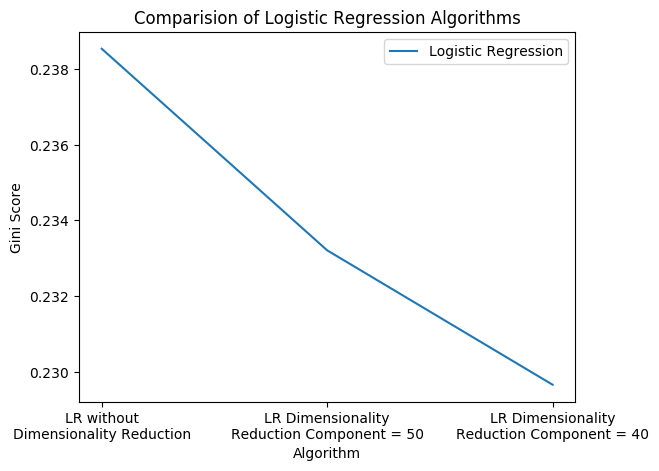

In [36]:
plt.plot([1, 2, 3], [lr_cross_score_mean, lr_cross_score_reduced_50_mean, lr_cross_score_reduced_40_mean], label='Logistic Regression')
plt.xticks([1,2,3], ['LR without\nDimensionality Reduction', 'LR Dimensionality\nReduction Component = 50', 'LR Dimensionality\nReduction Component = 40'])
plt.xlabel('Algorithm')
plt.ylabel('Gini Score')
plt.title('Comparision of Logistic Regression Algorithms')
plt.legend()
plt.show()
     

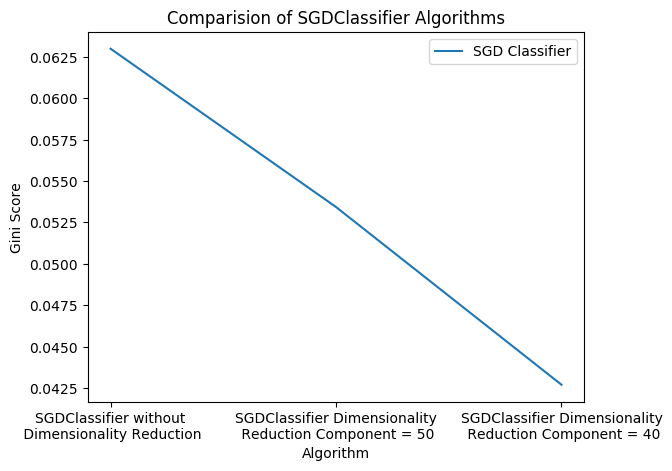

In [37]:
plt.plot([1, 2, 3], [sgd_cross_score_mean, sgd_cross_score_reduced_50_mean, sgd_cross_score_reduced_40_mean], label='SGD Classifier')
plt.xticks([1,2,3], ['SGDClassifier without\n Dimensionality Reduction', 'SGDClassifier Dimensionality\n Reduction Component = 50', 'SGDClassifier Dimensionality\n Reduction Component = 40'])
plt.xlabel('Algorithm')
plt.ylabel('Gini Score')
plt.title('Comparision of SGDClassifier Algorithms')
plt.legend()
plt.show()

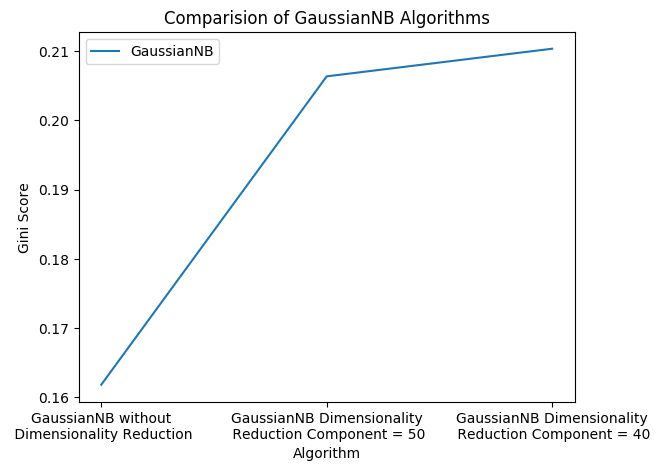

In [38]:
plt.plot([1, 2, 3], [gauss_cross_score_mean, gauss_cross_score_reduced_50_mean, gauss_cross_score_reduced_40_mean], label='GaussianNB')
plt.xticks([1,2,3], ['GaussianNB without\n Dimensionality Reduction', 'GaussianNB Dimensionality\n Reduction Component = 50', 'GaussianNB Dimensionality\n Reduction Component = 40'])
plt.xlabel('Algorithm')
plt.ylabel('Gini Score')
plt.title('Comparision of GaussianNB Algorithms')
plt.legend()
plt.show()

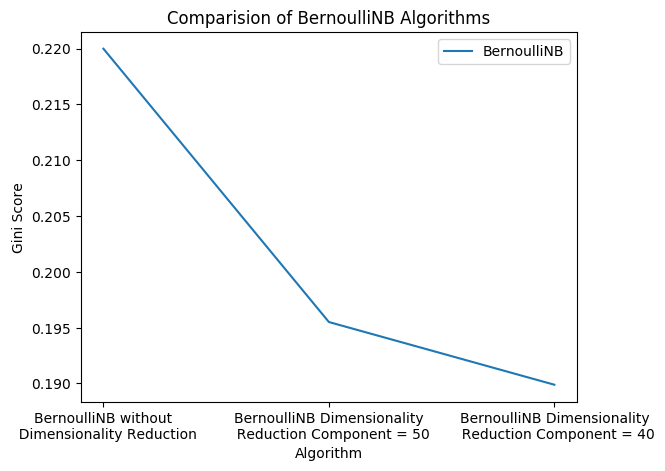

In [39]:
plt.plot([1, 2, 3], [bernoulli_cross_score_mean, bernoulli_cross_score_reduced_50_mean, bernoulli_cross_score_reduced_40_mean], label='BernoulliNB')
plt.xticks([1,2,3], ['BernoulliNB without\n  Dimensionality Reduction', 'BernoulliNB Dimensionality\n  Reduction Component = 50', 'BernoulliNB Dimensionality\n  Reduction Component = 40'])
plt.xlabel('Algorithm')
plt.ylabel('Gini Score')
plt.title('Comparision of BernoulliNB Algorithms')
plt.legend()
plt.show()

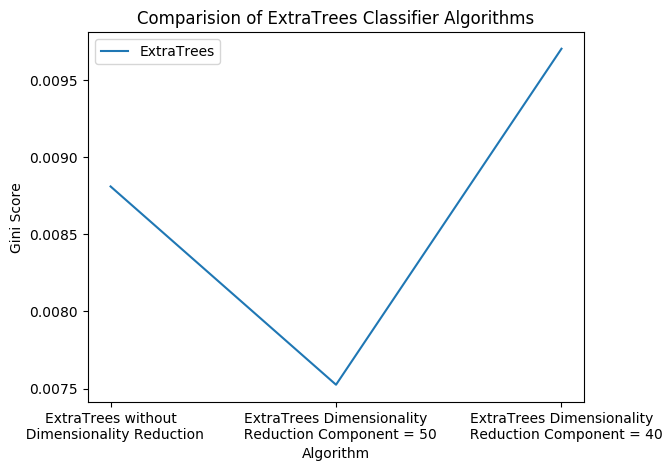

In [40]:
plt.plot([1, 2, 3], [et_cross_score_mean, et_cross_score_reduced_50_mean, et_cross_score_reduced_40_mean], label='ExtraTrees')
plt.xticks([1,2,3], ['ExtraTrees without\n  Dimensionality Reduction', 'ExtraTrees Dimensionality\n  Reduction Component = 50', 'ExtraTrees Dimensionality\n  Reduction Component = 40'])
plt.xlabel('Algorithm')
plt.ylabel('Gini Score')
plt.title('Comparision of ExtraTrees Classifier Algorithms')
plt.legend()
plt.show()

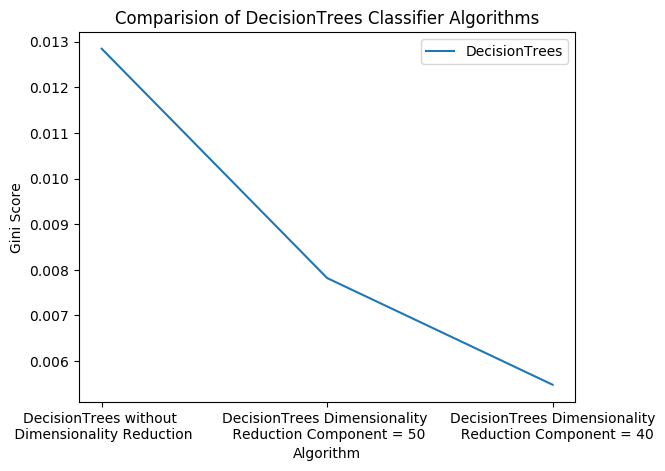

In [41]:
plt.plot([1, 2, 3], [dt_cross_score_mean, dt_cross_score_reduced_50_mean, dt_cross_score_reduced_40_mean], label='DecisionTrees')
plt.xticks([1,2,3], ['DecisionTrees without \n Dimensionality Reduction', 'DecisionTrees Dimensionality \n Reduction Component = 50', 'DecisionTrees Dimensionality\n  Reduction Component = 40'])
plt.xlabel('Algorithm')
plt.ylabel('Gini Score')
plt.title('Comparision of DecisionTrees Classifier Algorithms')
plt.legend()
plt.show()

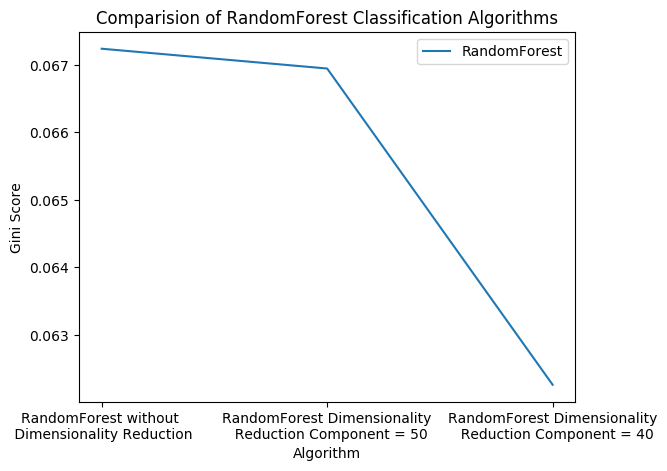

In [42]:
plt.plot([1, 2, 3], [rf_cross_score_mean, rf_cross_score_reduced_50_mean, rf_cross_score_reduced_40_mean], label='RandomForest')
plt.xticks([1,2,3], ['RandomForest without \n Dimensionality Reduction', 'RandomForest Dimensionality\n  Reduction Component = 50', 'RandomForest Dimensionality\n  Reduction Component = 40'])
plt.xlabel('Algorithm')
plt.ylabel('Gini Score')
plt.title('Comparision of RandomForest Classification Algorithms')
plt.legend()
plt.show()

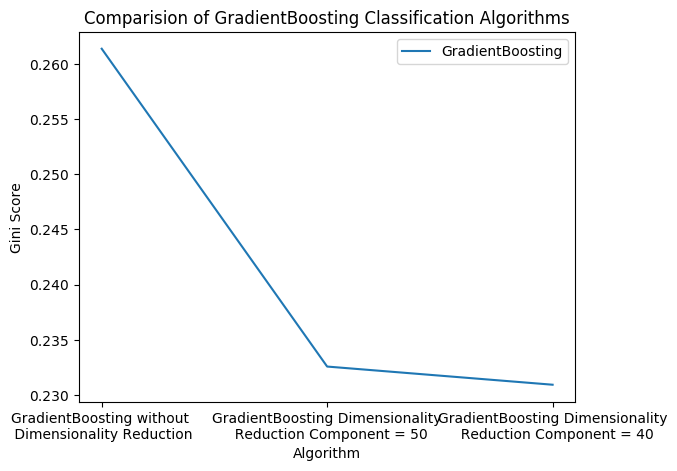

In [54]:
plt.plot([1, 2, 3], [gb_cross_score_mean, gb_cross_score_reduced_50_mean, gb_cross_score_reduced_40_mean], label='GradientBoosting')
plt.xticks([1,2,3], ['GradientBoosting without \n Dimensionality Reduction', 'GradientBoosting Dimensionality\n  Reduction Component = 50', 'GradientBoosting Dimensionality\n  Reduction Component = 40'])
plt.xlabel('Algorithm')
plt.ylabel('Gini Score')
plt.title('Comparision of GradientBoosting Classification Algorithms')
plt.legend()
plt.show()

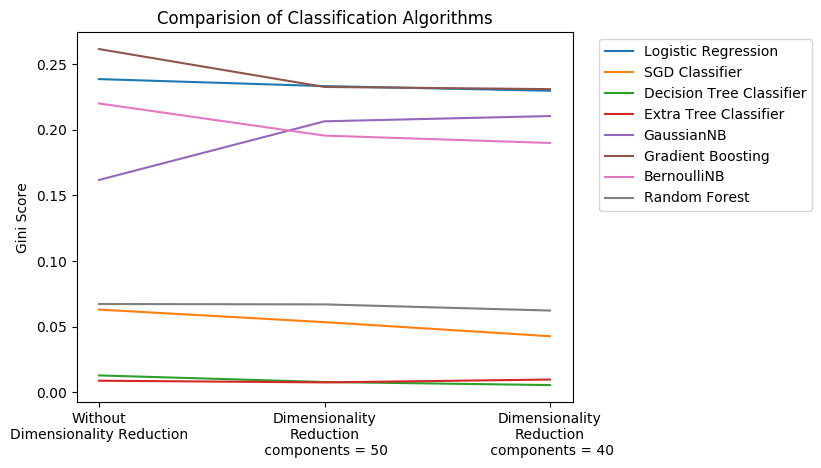

In [64]:
plt.plot([1, 2, 3], [lr_cross_score_mean, lr_cross_score_reduced_50_mean, lr_cross_score_reduced_40_mean], label='Logistic Regression')
plt.plot([1, 2, 3], [sgd_cross_score_mean, sgd_cross_score_reduced_50_mean, sgd_cross_score_reduced_40_mean], label='SGD Classifier')
plt.plot([1, 2, 3], [dt_cross_score_mean, dt_cross_score_reduced_50_mean, dt_cross_score_reduced_40_mean], label='Decision Tree Classifier')
plt.plot([1, 2, 3], [et_cross_score_mean, et_cross_score_reduced_50_mean, et_cross_score_reduced_40_mean], label='Extra Tree Classifier')
plt.plot([1, 2, 3], [gauss_cross_score_mean, gauss_cross_score_reduced_50_mean, gauss_cross_score_reduced_40_mean], label='GaussianNB')
plt.plot([1, 2, 3], [gb_cross_score_mean, gb_cross_score_reduced_50_mean, gb_cross_score_reduced_40_mean], label='Gradient Boosting')
plt.plot([1, 2, 3], [bernoulli_cross_score_mean, bernoulli_cross_score_reduced_50_mean, bernoulli_cross_score_reduced_40_mean], label='BernoulliNB')
plt.plot([1, 2, 3], [rf_cross_score_mean, rf_cross_score_reduced_50_mean, rf_cross_score_reduced_40_mean], label='Random Forest')

plt.xticks([1, 2, 3], ['Without\nDimensionality Reduction', 'Dimensionality\nReduction\n components = 50', 'Dimensionality\nReduction\n components = 40'])
plt.ylabel('Gini Score')
plt.title('Comparision of Classification Algorithms')
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()